# Task

The task is to do simple EDA on the dataset and find the solution to classification problem.

# Imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, StandardScaler

In [2]:
SEED = 42

# Loading Data

In [3]:
path = "data/complex_classification.csv"

In [4]:
df = pd.read_csv(path, index_col=0)

## Dataset Overview

In [5]:
df

,features_1,features_2,features_3,label
0,2.5,0.00,58,B
1,2.5,0.02,61,B
2,2.5,0.05,33,B
3,2.5,0.07,89,B
4,2.5,0.10,58,B
...,...,...,...,...
2511,12.0,9.91,93,A
2512,12.0,9.93,80,A
2513,12.0,9.95,37,A
2514,12.0,9.97,41,A


## Dataset Close Look

In this section, let's look at what columns we have, what type they are, how many non-zero values, etc.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2516 entries, 0 to 2515
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   features_1  2516 non-null   float64
 1   features_2  2516 non-null   float64
 2   features_3  2516 non-null   int64  
 3   label       2516 non-null   object 
dtypes: float64(2), int64(1), object(1)
memory usage: 98.3+ KB


In [7]:
assert df.isnull().values.any() == False

There are no missing values.  

We have:
* two float columns (`features_1` and `features_2`)
* one integer column (`features_3`)
* target column with string values (`label`)

# Data Analysis

## Correlation analysis

In [8]:
df.corr()

,features_1,features_2,features_3
features_1,1.000000,0.907025,-0.027539
features_2,0.907025,1.000000,-0.033328
features_3,-0.027539,-0.033328,1.000000


Features one and two are perfectly correlated.

## Numerical features

### Pairplot 

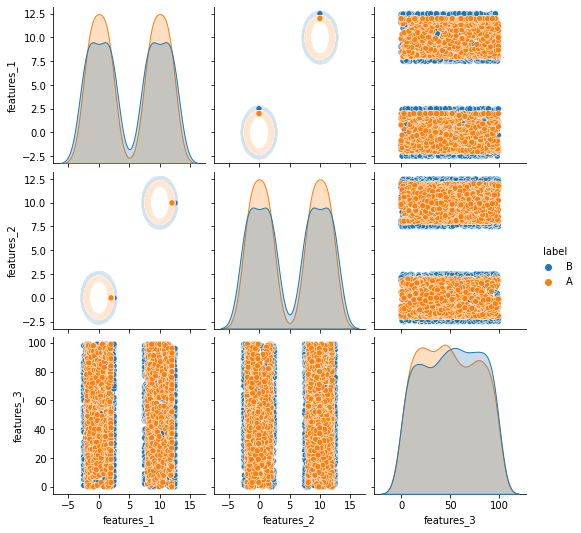

In [9]:
sns.pairplot(df, hue="label");

We can see that all the features are synthetic: first two features are the equations for the circles and the third feature is a synthetic noise.  
Let's look at them closely.

### Feature 1 and 2 dependency

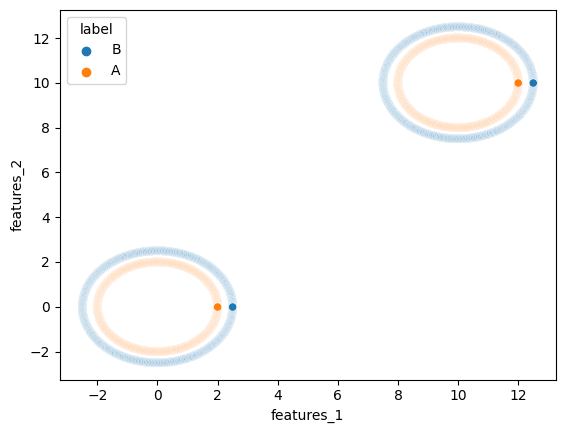

In [10]:
sns.scatterplot(data=df, hue="label", x="features_1", y="features_2");

Yep. `features_1` and `features_2` are circles and cannot be easily separated. We need to think about it.

### Dependency with 3rd feature

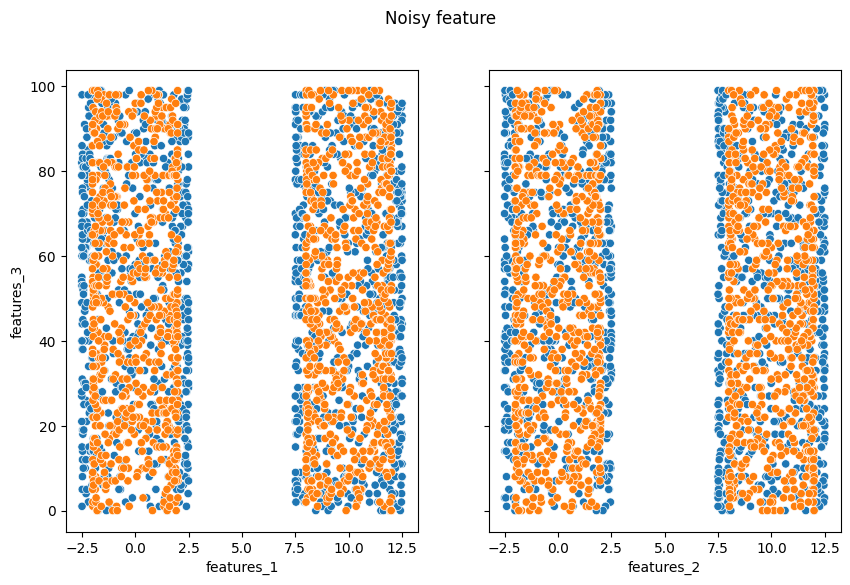

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 6), sharey=True)
fig.suptitle("Noisy feature")

g1 = sns.scatterplot(
    data=df, hue="label", x="features_1", y="features_3", ax=axs[0], legend=False
)
g2 = sns.scatterplot(
    data=df, hue="label", x="features_2", y="features_3", ax=axs[1], legend=False
);

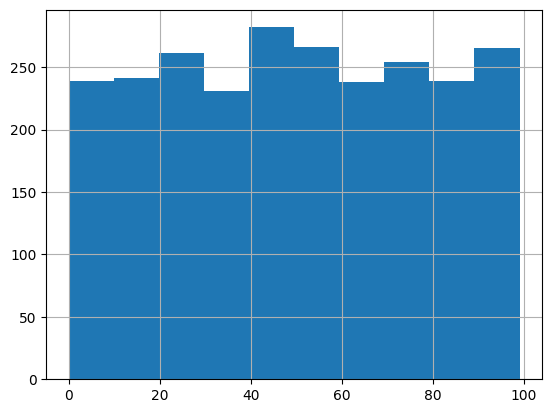

In [12]:
df["features_3"].hist();

Yes, this feature will not help us to solve the problem.

### Target variable

In [13]:
target_col = "label"

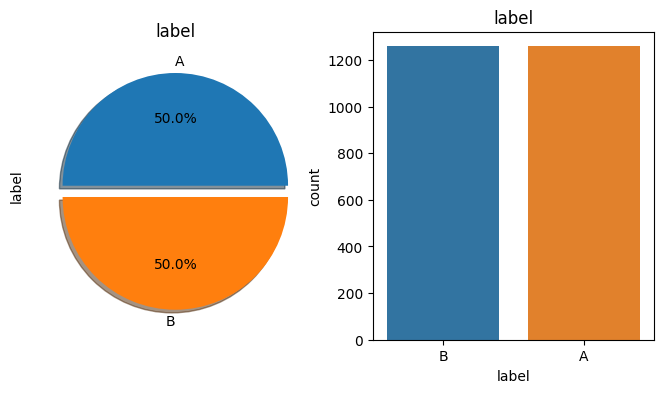

In [14]:
f, ax = plt.subplots(1, 2, figsize=(8, 4))
df[target_col].value_counts().plot.pie(
    explode=[0, 0.1], autopct="%1.1f%%", ax=ax[0], shadow=True
)
ax[0].set_title(target_col)
ax[0].set_ylabel(target_col)
sns.countplot(x=target_col, data=df, ax=ax[1])
ax[1].set_title(target_col)
plt.show()

The target feature is perfectly balanced, but is not numeric - we will have to encode it to be able to train the classifier.

### Duplicates

In [15]:
df.shape, df.drop_duplicates().shape

((2516, 4), (2516, 4))

We can see that we don't have duplicates

## Feature engineering

To solve this problem we will move two circles so they will match another two circles

In [16]:
new_df_1 = df[(df["features_1"] <= 5) & (df["features_2"] <= 5)].copy()
new_df_2 = df[(df["features_1"] > 5) & (df["features_2"] > 5)].copy()

In [17]:
new_df_1["best_feature"] = new_df_1["features_1"] ** 2 + new_df_1["features_2"] ** 2
new_df_2["best_feature"] = (new_df_2["features_1"] - 10) ** 2 + (
    new_df_2["features_2"] - 10
) ** 2

In [18]:
new_df = pd.concat([new_df_1, new_df_2])

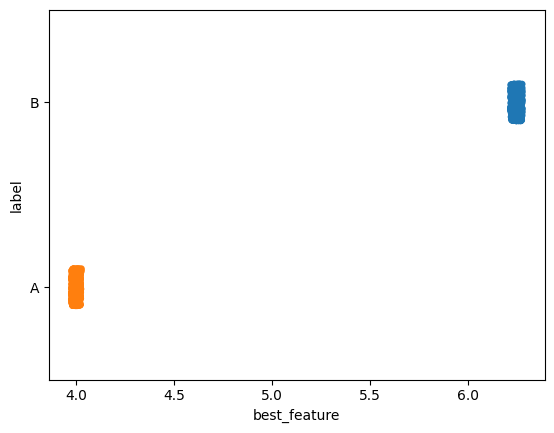

In [19]:
sns.stripplot(data=new_df, y="label", x="best_feature");

## Data splitting

We'll be using only one feature - new feature, which we generated one step ago.

In [20]:
X_train, X_val, y_train, y_val = train_test_split(
    new_df["best_feature"], new_df["label"], random_state=SEED
)

In [21]:
X_train.shape, X_val.shape

((1887,), (629,))

## Label encoding

In [22]:
le = LabelEncoder()

In [23]:
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)

## Scaling

In [24]:
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train.values.reshape(-1, 1))
X_val_scaled = sc.transform(X_val.values.reshape(-1, 1))

# Modelling

In [25]:
log_reg = LogisticRegression(random_state=SEED)

In [26]:
log_reg.fit(X_train_scaled, y_train_enc)

LogisticRegression(random_state=42)

In [27]:
y_pred = log_reg.predict(X_val_scaled)

In [28]:
f1 = f1_score(y_val_enc, y_pred)

In [29]:
f1

1.0

In [30]:
log_reg.coef_

array([[5.7856949]])

As we can see, classifier trained on one feature can perfectly solve this problem (because it is synthetic dataset)